# LLM Probing for Financial Signals

## Context
My PhD research focuses on mechanistic interpretability — understanding what information is encoded inside LLM representations. My ICLR 2025 paper (NNsight/NDIF) built infrastructure for probing LLM internals at scale.

Before investing compute in fine-tuning an LLM on financial text, I agree that we should first *probe* the model to understand what financial knowledge already exists in its representations, and at which layers.

## Pipeline
Toy financial text -> Extract hidden states per layer -> Train logistic regression on hidden states at each layer -> identify which layers encode financial signals

**This notebook uses nnterp** (standardized wrapper around nnsight, my lab's tool) for clean hidden state extraction.

## Why This Matters for Numerai
- Different layers typically encode different information: early layers capture syntax, middle layers capture semantics, late layers capture task-specific features. I spoke a bit about this with Mike during the interview. Relevant blog post here: https://sidn.baulab.info/stages/
- grabbing layers with the richest representation will likely yield better features (need to test)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nnterp import StandardizedTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

## 1. Load a Small Language Model
We use Gemma-3-270M-IT (270M params, 18 transformer layers, 2048 hidden dim) for demonstration. In production, you'd probe larger models (Llama-3, Mistral) or financial-specific models.

In [2]:
model_name = "google/gemma-3-270m-it"
model = StandardizedTransformer(model_name, device_map="auto", dispatch=True)

n_layers = model.config.num_hidden_layers
hidden_dim = model.config.hidden_size
print(f"Model: {model_name}")
print(f"Layers: {n_layers}, Hidden dim: {hidden_dim}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

Model: google/gemma-3-270m-it
Layers: 18, Hidden dim: 640
Parameters: 268,098,176


## 2. Financial Text Dataset with Labels
We create headlines labeled with return direction (up/down). Does Gemma-3 encode return-relevant information, and at which layer?

In [22]:
# Financial headlines with binary return labels
# In production: real headlines + real returns

data = [
    # Positive returns (label=1)
    ("Apple reports record quarterly revenue exceeding all analyst estimates", 1),
    ("NVIDIA data center revenue surges 400% on AI chip demand", 1),
    ("Microsoft Azure growth re-accelerates beating expectations", 1),
    ("Company announces massive share buyback program boosting stock", 1),
    ("Strong jobs report signals robust economic growth ahead", 1),
    ("Tech giant beats earnings estimates by wide margin", 1),
    ("Breakthrough drug receives FDA approval for rare disease", 1),
    ("Major acquisition deal completed at premium valuation", 1),
    ("Company raises full-year guidance citing strong demand", 1),
    ("Revenue growth accelerates driven by new product launch", 1),
    ("Profit margins expand as cost cutting measures take effect", 1),
    ("Company wins billion dollar government defense contract", 1),
    ("Subscriber growth exceeds expectations in latest quarter", 1),
    ("New partnership with industry leader boosts outlook", 1),
    ("Company achieves profitability ahead of schedule", 1),
    ("Strong holiday sales drive record fourth quarter results", 1),
    ("Analyst upgrades stock citing improved business fundamentals", 1),
    ("Company expands market share in key growth segment", 1),
    ("Cash flow reaches record high enabling increased dividends", 1),
    ("Patent portfolio expansion strengthens competitive position", 1),
    # Negative returns (label=0)
    ("Company misses revenue expectations amid weakening demand", 0),
    ("Tesla recalls 2 million vehicles over safety concerns", 0),
    ("Major data breach exposes millions of customer records", 0),
    ("Company announces significant workforce reduction layoffs", 0),
    ("Regulatory investigation launched into business practices", 0),
    ("Supply chain disruptions force production shutdown", 0),
    ("Product recall due to safety defects affects millions", 0),
    ("Company warns of lower guidance citing headwinds", 0),
    ("Unexpected quarterly loss shocks Wall Street analysts", 0),
    ("Key executive departure raises governance concerns", 0),
    ("Antitrust lawsuit threatens core business model", 0),
    ("Credit rating downgrade increases borrowing costs", 0),
    ("Market share losses accelerate in competitive landscape", 0),
    ("Accounting irregularities discovered during audit review", 0),
    ("Failed clinical trial sends biotech shares plummeting", 0),
    ("Trade restrictions limit access to key international market", 0),
    ("Debt levels raise concerns about financial sustainability", 0),
    ("Customer churn rate increases in latest reporting period", 0),
    ("Class action lawsuit filed against company by shareholders", 0),
    ("Competitor launches superior product at lower price point", 0),
]

texts = [t for t, _ in data]
labels = [l for _, l in data]

## 3. Extract Hidden States at Every Layer

This is the core of probing. We use **nnterp** (a standardized wrapper around nnsight, my ICLR 2025 paper) to cleanly extract hidden states from every transformer layer. The key advantage: `model.layers_output[i]` works identically across all HuggingFace architectures — no need to know the model-specific module names.

We use the last token's representation (standard for causal LMs with left-to-right attention).

In [23]:
model

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((640,), eps=1e-06)

In [24]:
import nnsight


def extract_hidden_states(texts: list[str], model) -> dict[int, np.ndarray]:
    """Extract hidden states from every layer for each text.

    Returns: dict mapping layer_idx -> np.array of shape (n_texts, hidden_dim)
    """
    out_dct = {}
    with model.trace(texts):
        for i, layer in enumerate(model.model.layers):
            print(layer.output.shape)
            out_dct[i] = (
                nnsight.save(layer.output).detach().cpu().float().numpy().squeeze()
            )
    return out_dct


out_dct_base = extract_hidden_states(texts, model)

print(len(texts))
out_dct_base[0].shape


torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
torch.Size([40, 16, 640])
40


(40, 16, 640)

In [25]:
out_dct_base = {k: v[:, -1, :] for k, v in out_dct_base.items()}

## 4. Train Linear Probes Per Layer

A linear probe is a simple logistic regression trained on the hidden states to predict the label. If a layer's probe has high accuracy, that layer encodes the relevant information.

**This is the key experiment**: which layer of Gemma-3 best encodes financial sentiment/return direction?

In [26]:
# Train a linear probe at each layer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

num_folds = 5
scores = np.empty((len(out_dct_base.keys()), num_folds))
for layer_idx, X in out_dct_base.items():
    X = StandardScaler().fit_transform(X)
    probe = LogisticRegression()
    scores[layer_idx, :] = cross_val_score(estimator=probe, X=X, y=labels, cv=num_folds)


In [27]:
scores

array([[0.875, 0.5  , 0.375, 0.625, 0.625],
       [0.75 , 0.375, 0.5  , 0.5  , 0.75 ],
       [0.625, 0.625, 0.5  , 0.625, 0.625],
       [0.75 , 0.75 , 0.5  , 0.75 , 0.25 ],
       [0.75 , 0.5  , 0.625, 0.875, 0.625],
       [0.875, 0.625, 0.5  , 0.75 , 0.5  ],
       [0.875, 0.625, 0.375, 0.625, 0.625],
       [0.875, 0.75 , 0.75 , 0.375, 0.625],
       [0.875, 0.625, 0.75 , 0.75 , 0.875],
       [0.875, 0.75 , 0.625, 0.75 , 0.625],
       [0.875, 0.75 , 0.875, 0.875, 0.625],
       [0.875, 0.75 , 0.75 , 0.875, 0.625],
       [0.875, 0.75 , 0.75 , 0.625, 0.625],
       [0.875, 0.875, 0.75 , 0.625, 0.625],
       [0.875, 0.875, 0.75 , 0.875, 0.625],
       [0.875, 0.875, 0.875, 0.875, 0.75 ],
       [0.875, 0.875, 0.75 , 0.875, 0.75 ],
       [0.75 , 0.875, 0.75 , 0.875, 0.75 ]])

## 5. Probe accuracy by layer
Where in the network is financially-relevant information encoded?

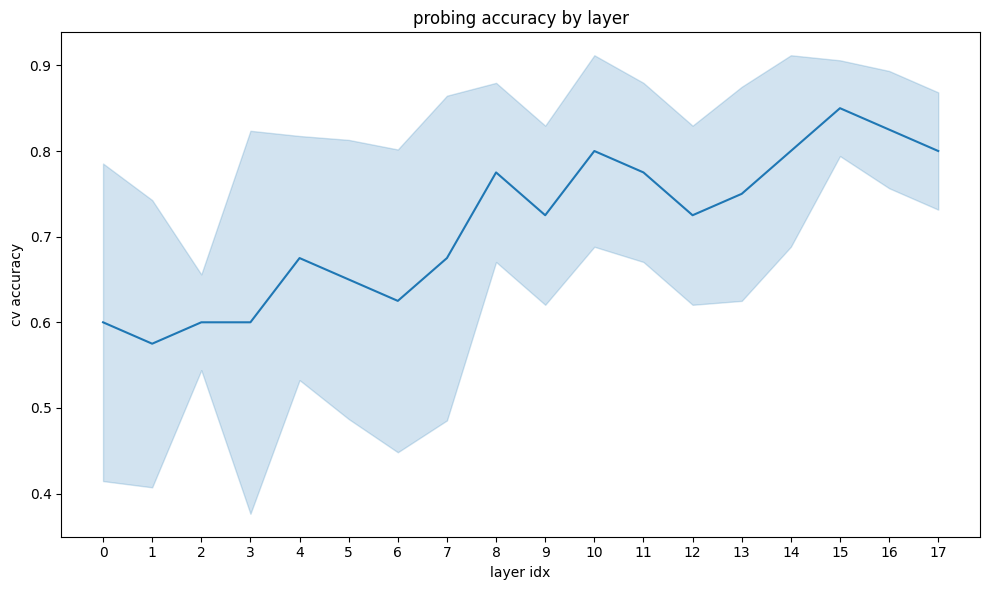

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Calculate mean and std across folds for each layer

df = pd.DataFrame({
    "layer": np.repeat(np.arange(n_layers), num_folds),
    "fold": np.tile(np.arange(num_folds), n_layers),
    "accuracy": scores.flatten(),
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="layer", y="accuracy", errorbar="sd")
plt.xlabel("layer idx")
plt.ylabel("cv accuracy")
plt.title("probing accuracy by layer")
plt.xticks(ticks=np.arange(n_layers), labels=np.arange(n_layers))

plt.tight_layout()
plt.show()

## On shuffled labels as a sanity check

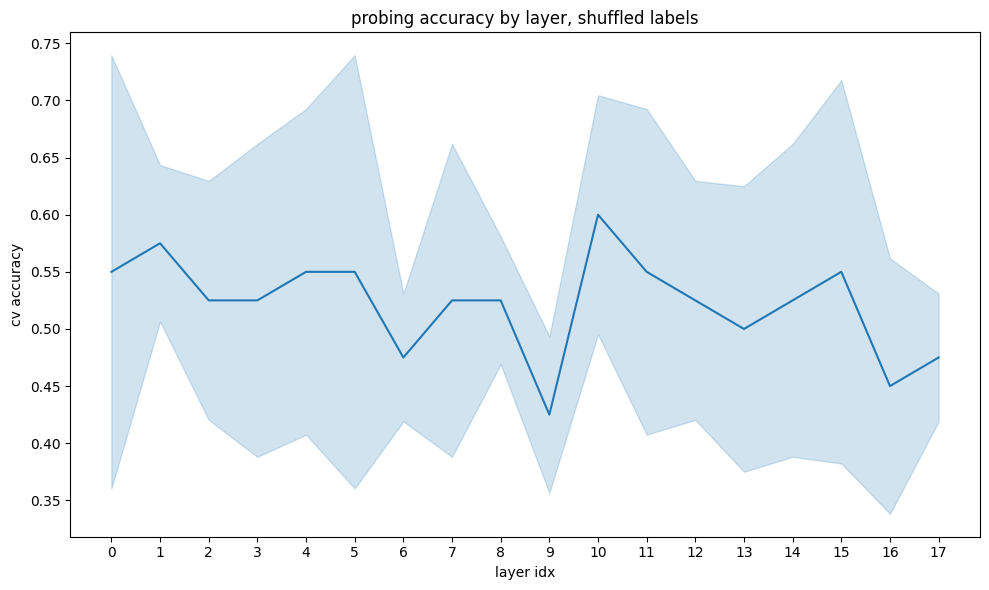

In [21]:
# Train a linear probe at each layer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

num_folds = 5
labels_shuffled = np.random.permutation(labels)
scores = np.empty((len(out_dct_base.keys()), num_folds))
for layer_idx, X in out_dct_base.items():
    X = StandardScaler().fit_transform(X)
    probe = LogisticRegression()
    scores[layer_idx, :] = cross_val_score(
        estimator=probe, X=X, y=labels_shuffled, cv=num_folds
    )


# Calculate mean and std across folds for each layer
df = pd.DataFrame({
    "layer": np.repeat(np.arange(n_layers), num_folds),
    "fold": np.tile(np.arange(num_folds), n_layers),
    "accuracy": scores.flatten(),
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="layer", y="accuracy", errorbar="sd")
plt.xlabel("layer idx")
plt.ylabel("cv accuracy")
plt.title("probing accuracy by layer, shuffled labels")
plt.xticks(ticks=np.arange(n_layers), labels=np.arange(n_layers))

plt.tight_layout()
plt.show()


## 6. Compare Feature Quality Across Layers
Use the best probing layer as the feature extractor, not the last layer.

In [ ]:
# Compare embeddings from different layers


## 7. Using Probing Results for Feature Engineering

The practical implication: **don't just use the last layer**. Use the layer where financial information is most accessible.

In [ ]:
# Practical comparison: features from last layer vs best probing layer

# TODO: implement
...

## Discussion

- Standard practice is to use the last layer or [CLS] token. Probing reveals that this is often suboptimal.
- **NNsight/NDIF** (my ICLR paper) makes this trivial at scale. We built infrastructure to probe any open-weight model without engineering overhead. Loads on top of huggingface transformers.
- **nnterp** standardizes layer access across architectures: `model.layers_output[i]` works for Gemma, Llama, Mistral, etc.
- **David Bau's lab** (my PhD advisor) pioneered network dissection and representation engineering; we are pretty definitively the top lab in the field.

### Extensions (TODO)
- [ ] Probe for more nuanced labels: return magnitude, volatility, sector
- [ ] Compare probing curves across models: Gemma-3, Llama-3, FinBERT, SmolLM
- [ ] Multi-layer feature concatenation (best 3 layers)
- [ ] Causal probing: not just where, but HOW financial knowledge is encoded
- [ ] Probing with larger datasets (1000+ headlines with real returns)